In [3]:
import zipfile

# Importing the tarfile module for working with tar files
import tarfile
# Importing all neccessary modeules
import spacy
import pandas as pd
from pathlib import Path
import sys
import re
import joblib


In [4]:
 # Mount google drive if google colab is being used
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path = '/content/spam.csv'
try:
    emails_df = pd.read_csv(file_path, encoding='utf-8')
except UnicodeDecodeError:
    try:
        emails_df = pd.read_csv(file_path, encoding='latin1')
    except UnicodeDecodeError:
        try:
            emails_df = pd.read_csv(file_path, encoding='ISO-8859-1')
        except UnicodeDecodeError:
            emails_df = pd.read_csv(file_path, encoding='cp1252')

In [6]:
# Set base folder and append custome module paths
if 'google.colab' in str(get_ipython()):
  !pip install -U nltk -qq
  !pip install -U spacy -qq
  !python -m spacy download en_core_web_sm -qq
  base_folder = Path('/content/drive/MyDrive/base_folder')
  sys.path.append('/content/drive/MyDrive/custom_functions')
else:
    base_folder = Path('/content/drive/MyDrive/base_folder')
    sys.path.append('/content/drive/MyDrive/custom_functions')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 42.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
data_folder = base_folder/'datasets'
archive_folder = base_folder/'archive'
model_folder = base_folder/'models'

In [8]:
# Download spacy model
if 'google.colab' in str(get_ipython()):
    !python -m spacy download en_core_web_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [9]:
# Read csv file into a dataframe
df = pd.read_csv('spam.csv', encoding="ISO-8859-1")

In [10]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [11]:
df.shape

(5572, 5)

In [12]:
# Install and import the swifter module
!pip install swifter
import swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=5c2042746c1b76f2a818f2e0a3de38cfd410bd90cbfd51c3a57083c10f0f8da2
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


In [13]:
# Renaming the main columns needed and dropping unused columns
df.rename(columns={'v1': 'label', 'v2': 'message'}, inplace = True)
df = df.drop(labels=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [14]:
# Get the percentage of spam observations to the percentage of ham
perc_of_spam = sum(df['label'].swifter.apply(lambda x: 1 if x == "spam" else 0))/len(df) * 100

Pandas Apply:   0%|          | 0/5572 [00:00<?, ?it/s]

In [15]:
print("The percentage of spam in the dataset is", perc_of_spam, "While the percentage of ham is", 100 - perc_of_spam)

The percentage of spam in the dataset is 13.406317300789663 While the percentage of ham is 86.59368269921033


In [16]:
# Import required nltk packages
import nltk
nltk.download('stopwords')  # Download the stopwords corpus
from nltk.corpus import stopwords as nltk_stopwords  # Stopwords corpus

# Import tweet tokenizer from nltk
from nltk.tokenize import TweetTokenizer

# Import CountVectorizer and TfidfVectorizer from scikit-learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
# Import the joblib library for saving and loading models
import joblib

# Import scikit-learn classes for building models
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator

# Import the scipy library for working with sparse matrices
from scipy.sparse import csr_matrix

In [18]:
import custom_preprocessor_mod as cp
from  featurizer import ManualFeatures


In [19]:
# Change the label column into ones and zeroes (1 for spam email and 0 for non-spam)
df['label'] = df['label'].swifter.apply(lambda x: 1 if x=="spam" else 0)

Pandas Apply:   0%|          | 0/5572 [00:00<?, ?it/s]

In [20]:
len(df)

5572

In [21]:
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [22]:
df_cleaned = cp.SpacyPreprocessor(model = "en_core_web_sm").transform(df['message'].values)

/content/drive/MyDrive/custom_functions/custom_preprocessor_mod.py:90: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [23]:
# save this to a file
file_df_cleaned_sparse_embed = data_folder / 'df_cleaned_sparse_embed.pkl'
joblib.dump(df_cleaned, file_df_cleaned_sparse_embed)

['/content/drive/MyDrive/base_folder/datasets/df_cleaned_sparse_embed.pkl']

In [24]:
cleaned_text_df = joblib.load(file_df_cleaned_sparse_embed)

In [25]:
# Create an instance of the ManualFeatures class
featurizer = ManualFeatures(spacy_model='en_core_web_sm')

In [26]:
# Transform the X_train data into manual features
X_features_values, feature_names = featurizer.fit_transform(cleaned_text_df)

In [27]:
# Convert the numpy array into a dataframe
spam_df = pd.DataFrame(X_features_values, columns = feature_names)

In [28]:
spam_df.head()

,count_words,count_characters,count_characters_no_space,avg_word_length,count_digits,count_numbers,noun_count,aux_count,verb_count,adj_count,ner
0,15.0,79.0,65.0,4.062500,0.0,0.0,1.0,10.0,0.0,2.0,2.0
1,6.0,21.0,16.0,2.285714,0.0,0.0,0.0,4.0,0.0,0.0,1.0
2,19.0,119.0,101.0,5.050000,25.0,6.0,4.0,13.0,0.0,2.0,3.0
3,6.0,19.0,14.0,2.000000,0.0,0.0,0.0,6.0,0.0,0.0,0.0
4,5.0,21.0,17.0,2.833333,0.0,0.0,0.0,0.0,0.0,3.0,0.0


In [29]:
# Download pyspellchecker
! pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 50.7 MB/s eta 0:00:00


In [30]:
from spellchecker import SpellChecker

spell = SpellChecker()

def check_spelling(sentence):
  misspelled = spell.unknown(re.findall(r"[\w']+|[.,!?;]", sentence))
  return len(misspelled)

In [31]:
# Convert the numpy array of text into a dataframe
spam_text = pd.DataFrame(cleaned_text_df)

In [32]:
spam_text.head()

,0
0,jurong point crazy available bugis n great wor...
1,ok lar joke wif u oni
2,free entry 2 wkly comp win fa cup final tkts 2...
3,u dun early hor u c
4,nah think go usf live


In [33]:
# Include an additional column in the train data that shows the number of mistakes in the sentence
spam_df['no_of_spelling_mistakes'] = spam_text[0].swifter.apply(lambda x: check_spelling(x))

Pandas Apply:   0%|          | 0/5572 [00:00<?, ?it/s]

In [34]:
spam_df.head()

,count_words,count_characters,count_characters_no_space,avg_word_length,count_digits,count_numbers,noun_count,aux_count,verb_count,adj_count,ner,no_of_spelling_mistakes
0,15.0,79.0,65.0,4.062500,0.0,0.0,1.0,10.0,0.0,2.0,2.0,3
1,6.0,21.0,16.0,2.285714,0.0,0.0,0.0,4.0,0.0,0.0,1.0,3
2,19.0,119.0,101.0,5.050000,25.0,6.0,4.0,13.0,0.0,2.0,3.0,7
3,6.0,19.0,14.0,2.000000,0.0,0.0,0.0,6.0,0.0,0.0,0.0,1
4,5.0,21.0,17.0,2.833333,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1


In [35]:
spam_df_combined = pd.concat((pd.DataFrame(spam_text),
                              pd.DataFrame(spam_df)), axis = 1)

In [36]:
spam_df_combined
###This is the combined dataset now

,0,count_words,count_characters,count_characters_no_space,avg_word_length,count_digits,count_numbers,noun_count,aux_count,verb_count,adj_count,ner,no_of_spelling_mistakes
0,jurong point crazy available bugis n great wor...,15.0,79.0,65.0,4.062500,0.0,0.0,1.0,10.0,0.0,2.0,2.0,3
1,ok lar joke wif u oni,6.0,21.0,16.0,2.285714,0.0,0.0,0.0,4.0,0.0,0.0,1.0,3
2,free entry 2 wkly comp win fa cup final tkts 2...,19.0,119.0,101.0,5.050000,25.0,6.0,4.0,13.0,0.0,2.0,3.0,7
3,u dun early hor u c,6.0,19.0,14.0,2.000000,0.0,0.0,0.0,6.0,0.0,0.0,0.0,1
4,nah think go usf live,5.0,21.0,17.0,2.833333,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,2nd time try 2 contact u. u win å£750 pound pr...,16.0,85.0,70.0,4.117647,21.0,7.0,6.0,12.0,0.0,2.0,4.0,5
5568,ì b go esplanade fr home,6.0,24.0,19.0,2.714286,0.0,0.0,0.0,4.0,0.0,1.0,1.0,2
5569,pity mood suggestion,3.0,20.0,18.0,4.500000,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0
5570,guy bitching act like interested buy week give...,9.0,51.0,43.0,4.300000,0.0,0.0,0.0,4.0,0.0,2.0,2.0,0


In [37]:
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [38]:
spam_df_combined2 = pd.concat((pd.DataFrame(df),
                              pd.DataFrame(spam_df_combined)), axis = 1)

In [39]:
spam_df_combined2.head()

,label,message,0,count_words,count_characters,count_characters_no_space,avg_word_length,count_digits,count_numbers,noun_count,aux_count,verb_count,adj_count,ner,no_of_spelling_mistakes
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,15.0,79.0,65.0,4.062500,0.0,0.0,1.0,10.0,0.0,2.0,2.0,3
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni,6.0,21.0,16.0,2.285714,0.0,0.0,0.0,4.0,0.0,0.0,1.0,3
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,19.0,119.0,101.0,5.050000,25.0,6.0,4.0,13.0,0.0,2.0,3.0,7
3,0,U dun say so early hor... U c already then say...,u dun early hor u c,6.0,19.0,14.0,2.000000,0.0,0.0,0.0,6.0,0.0,0.0,0.0,1
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think go usf live,5.0,21.0,17.0,2.833333,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1


In [40]:
# Drop the 'message' column
spam_df_combined2 = spam_df_combined2.drop('message', axis=1)

# Rename the '0' column to 'message'
spam_df_combined2 = spam_df_combined2.rename(columns={0: 'message'})


In [41]:
spam_df_combined2.head()

,label,message,count_words,count_characters,count_characters_no_space,avg_word_length,count_digits,count_numbers,noun_count,aux_count,verb_count,adj_count,ner,no_of_spelling_mistakes
0,0,jurong point crazy available bugis n great wor...,15.0,79.0,65.0,4.062500,0.0,0.0,1.0,10.0,0.0,2.0,2.0,3
1,0,ok lar joke wif u oni,6.0,21.0,16.0,2.285714,0.0,0.0,0.0,4.0,0.0,0.0,1.0,3
2,1,free entry 2 wkly comp win fa cup final tkts 2...,19.0,119.0,101.0,5.050000,25.0,6.0,4.0,13.0,0.0,2.0,3.0,7
3,0,u dun early hor u c,6.0,19.0,14.0,2.000000,0.0,0.0,0.0,6.0,0.0,0.0,0.0,1
4,0,nah think go usf live,5.0,21.0,17.0,2.833333,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1


In [42]:
spam_df_combined2.to_csv('spam_df_combined_with_labels.csv', index=False)


In [43]:
from google.colab import files
files.download('spam_df_combined_with_labels.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
# Splitting the dataset into train and test samples. 50% of the data for each
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.8, random_state=10)


print(f'Shape of Training data set is : {train_data.shape}')
print(f'Shape of Test data set is : {test_data.shape}')

Shape of Training data set is : (1114, 2)
Shape of Test data set is : (4458, 2)


Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

X_train = train_data.drop('label', axis=1)
y_train = train_data['label']
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['message'])

# Transform the test text data
X_test_tfidf = tfidf_vectorizer.transform(X_test['message'])

# Initialize the Random Forest classifier and Fit the model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the vectorized test data
y_pred = rf_classifier.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3847
           1       0.99      0.63      0.77       611

    accuracy                           0.95      4458
   macro avg       0.97      0.81      0.87      4458
weighted avg       0.95      0.95      0.94      4458



Gradient Boosting

In [46]:
from sklearn.ensemble import GradientBoostingClassifier
# Initialize the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(random_state=42)
# Fit the model to the vectorized training data
gb_classifier.fit(X_train_tfidf, y_train)
# Make predictions on the vectorized test data
y_pred_gb = gb_classifier.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_gb))


              precision    recall  f1-score   support

           0       0.94      0.99      0.97      3847
           1       0.92      0.61      0.73       611

    accuracy                           0.94      4458
   macro avg       0.93      0.80      0.85      4458
weighted avg       0.94      0.94      0.93      4458



Decision Tree

In [47]:
from sklearn.tree import DecisionTreeClassifier
#Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier()
#Fit the model to the vectorized training data
dt_classifier.fit(X_train_tfidf, y_train)
# Make predictions on the vectorized test data
y_pred_dt = dt_classifier.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_dt))


              precision    recall  f1-score   support

           0       0.93      0.98      0.95      3847
           1       0.82      0.53      0.64       611

    accuracy                           0.92      4458
   macro avg       0.87      0.76      0.80      4458
weighted avg       0.91      0.92      0.91      4458



Support Vector Machine(SVM)

In [48]:
from sklearn.svm import OneClassSVM
# Initialize and train the One-Class SVM model
one_class_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
one_class_svm.fit(X_train_tfidf)

y_pred_smv = one_class_svm.predict(X_test_tfidf)

# Identify outliers
outliers = X_test[y_pred_smv == -1]

print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      3847
           1       0.82      0.53      0.64       611

    accuracy                           0.92      4458
   macro avg       0.87      0.76      0.80      4458
weighted avg       0.91      0.92      0.91      4458



In [51]:
# Indices of outliers
outlier_indices = [i for i, p in enumerate(y_pred_smv) if p == -1]

print("Indices of detected outliers:", outlier_indices)

if 'message' in X_test.columns:
    outlier_messages = X_test.iloc[outlier_indices]['message']
    print("\nMessages classified as outliers:\n", outlier_messages.head())
else:
    print("\nDataframe does not contain a 'message' column to display.")

Indices of detected outliers: [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 24, 25, 27, 28, 30, 31, 32, 33, 34, 35, 39, 40, 41, 44, 45, 47, 48, 49, 50, 53, 54, 57, 58, 62, 64, 65, 66, 67, 69, 70, 71, 73, 74, 75, 76, 77, 79, 81, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99, 100, 101, 102, 103, 104, 105, 107, 109, 110, 112, 113, 114, 115, 117, 119, 120, 122, 125, 126, 128, 129, 130, 131, 132, 136, 137, 139, 141, 143, 144, 147, 148, 150, 151, 152, 153, 154, 155, 157, 159, 160, 161, 162, 164, 166, 167, 168, 169, 172, 173, 175, 176, 177, 178, 180, 185, 186, 187, 188, 196, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 218, 219, 220, 221, 223, 224, 225, 226, 227, 228, 230, 232, 233, 234, 236, 237, 238, 239, 241, 242, 245, 246, 248, 249, 250, 251, 252, 253, 254, 255, 256, 261, 262, 263, 264, 265, 267, 268, 270, 271, 272, 273, 274, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 288, 289, 291, 292, 294, 295, 296, 297,

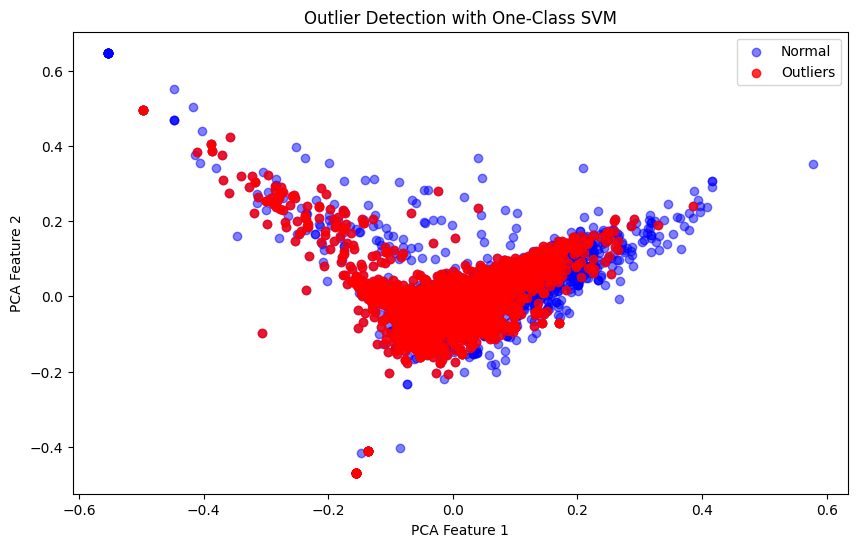

In [52]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_test_tfidf.toarray())

# Plot
plt.figure(figsize=(10, 6))
# Plot all points as blue
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], color='blue', label='Normal', alpha=0.5)
# Plot outliers as red
plt.scatter(X_reduced[outlier_indices, 0], X_reduced[outlier_indices, 1], color='red', label='Outliers', alpha=0.8)
plt.title('Outlier Detection with One-Class SVM')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.legend()
plt.show()
